In [1]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv

In [2]:
from llm_agents_introduction.alpha_vantage import AlphaVantageService

alpha_vantage = AlphaVantageService.create()

In [3]:
from datetime import date
from dataclasses import asdict
from pprint import pprint

news_links = alpha_vantage.fetch_relevant_news('MSFT', from_date=date(2023, 10, 1), to_date=date(2023, 12, 1))

print(f'Have {len(news_links)} news links')
pprint(asdict(news_links[0]))

Have 720 news links
{'overall_sentiment_score': 0.160819,
 'published_on': datetime.date(2023, 11, 24),
 'summary': 'Microsoft MSFT has outperformed the market over the past 15 years '
            'by 10.11% on an annualized basis producing an average annual '
            'return of 22.21%. Currently, Microsoft has a market '
            'capitalization of $2.80 trillion.',
 'ticker_sentiment': [{'relevance_score': 0.983605,
                       'ticker': 'MSFT',
                       'ticker_sentiment_score': 0.387251}],
 'title': "Here's How Much $1000 Invested In Microsoft 15 Years Ago Would Be "
          'Worth Today - Microsoft  ( NASDAQ:MSFT ) ',
 'url': 'https://www.benzinga.com/news/23/11/35939777/heres-how-much-1000-invested-in-microsoft-15-years-ago-would-be-worth-today'}


In [4]:
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(model='text-embedding-3-large')

summaries = [ news_link.summary for news_link in news_links ]
embeddings = embeddings_model.embed_documents(summaries)

In [45]:
from llm_agents_introduction.news_clustering import cluster_news_links

clusters = cluster_news_links(news_links, embeddings_model)

clusters

[[NewsLink(title="Sam Altman Says He Has Microsoft CEO's Support For Return To OpenAI", url='https://www.barrons.com/news/sam-altman-says-he-has-microsoft-ceo-s-support-for-return-to-openai-eeb98446', summary="Sam Altman Says He Has Microsoft CEO's Support For Return To ... ...", overall_sentiment_score=0.187181, published_on=datetime.date(2023, 11, 22), ticker_sentiment=[TickerSentiment(ticker='MSFT', relevance_score=0.922387, ticker_sentiment_score=0.323906)]),
  NewsLink(title="Sam Altman to return as OpenAI CEO, says looking forward to 'building on our strong partnership with Microsoft'", url='https://www.financialexpress.com/life/technology/sam-altman-to-return-as-openai-ceo-says-looking-forward-to-building-on-our-strong-partnership-with-microsoft-bkg/3313936/', summary="After last week's dramatic events at OpenAI, which saw appointment of new interim CEO and the staff threatening to resign, Sam Altman is returning to the company he co-founded in 2015.", overall_sentiment_score=0.

In [46]:
for cluster in clusters:
    print(f'Cluster with {len(cluster)} news links')
    for news_link in cluster[:3]:
        print(f' - {news_link.title}')
    print()


Cluster with 50 news links
 - Sam Altman Says He Has Microsoft CEO's Support For Return To OpenAI
 - Sam Altman to return as OpenAI CEO, says looking forward to 'building on our strong partnership with Microsoft'
 - Sam Altman In Discussions About OpenAI Return As Employees Revolt, Microsoft Picks Up The Pieces - Microsoft  ( NASDAQ:MSFT ) 

Cluster with 23 news links
 - Microsoft Continues to Invest Heavily in AI -- Good News for Nvidia Stock Investors?
 - Baidu's Results Proved Its Resilience Amid A Challenging Macroeconomic Backdrop - Baidu  ( NASDAQ:BIDU ) 
 - A Bull Market Is Coming: 1 Incredible Artificial Intelligence  ( AI )  Growth Stock to Buy Hand Over Fist and Hold Forever

Cluster with 21 news links
 - Microsoft And Other Investors' Seat On OpenAI's Board Seems Unlikely: Report - Microsoft  ( NASDAQ:MSFT ) 
 - OpenAI In 'Intense Discussions' to Prevent Staff Exodus: Report
 - OpenAI's path ahead is unclear as employees threaten to quit unless board resigns

Cluster with 21

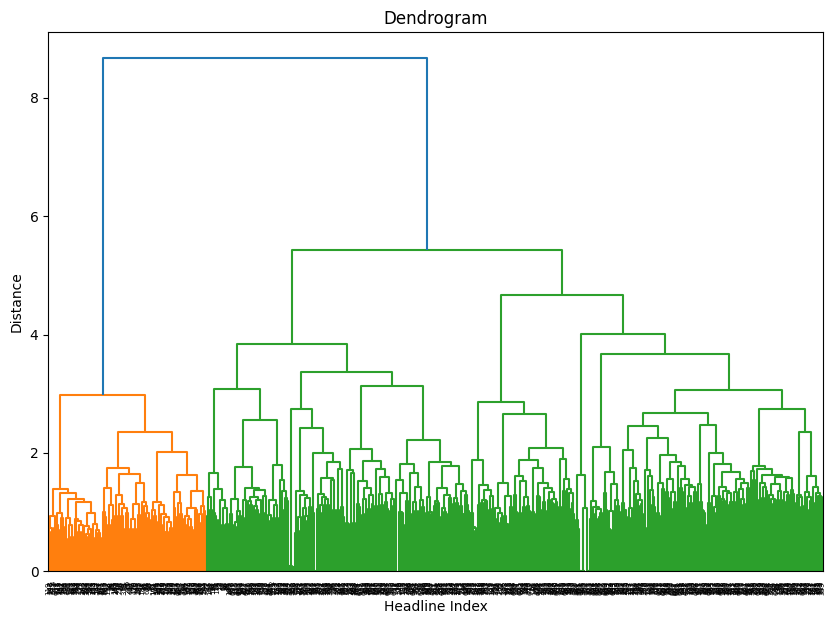

Cluster Sizes:
    cluster  size
0         1    50
1         2    45
2        28    43
3        17    42
4        14    41
5        27    40
6        25    38
7        12    36
8         6    35
9        10    31
10        4    31
11       13    29
12       15    22
13        5    21
14        3    21
15        7    20
16       16    18
17       30    18
18        9    16
19       21    16
20       18    15
21       23    14
22       19    14
23       20    13
24       24    12
25       11    10
26       26     9
27       22     7
28       29     7
29        8     6


[[1,
  ["Sam Altman Says He Has Microsoft CEO's Support For Return To OpenAI",
   "Sam Altman to return as OpenAI CEO, says looking forward to 'building on our strong partnership with Microsoft'",
   'Sam Altman In Discussions About OpenAI Return As Employees Revolt, Microsoft Picks Up The Pieces - Microsoft  ( NASDAQ:MSFT ) ',
   'Shakeup At OpenAI: Sam Altman Returns As CEO, Microsoft Secures Board Observer Role - Microsoft  ( NASDAQ:MSFT ) ',
   'Could Altman Return? Ousted OpenAI Founder Reportedly In Reunion Talks-Despite Microsoft Deal',
   "Sam Altman: The man who played 'UNO Reverse' card on OpenAI's board",
   "Sam Altman To Return As OpenAI CEO As New Board Collaborating 'To Figure Out Details' - Microsoft  ( NASDAQ:MSFT ) ",
   'OpenAI to rehire Sam Altman as CEO with new initial board members',
   'Sam Altman returns to OpenAI in a bizarre reversal of fortunes | Business',
   'Sam Altman To Return As OpenAI CEO After Shock Ouster',
   "OpenAI's Altman U-Turn: The Winners An

In [19]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
import pandas as pd

# Compute the linkage matrix
Z = linkage(embeddings, method='ward')

# Plot the dendrogram to visualize the clustering
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Headline Index')
plt.ylabel('Distance')
plt.show()

# Define a threshold to cut the dendrogram
threshold = 2.0  # Adjust this value based on your data

# Form clusters
clusters = fcluster(Z, threshold, criterion='distance')

# Create a DataFrame with headlines and their cluster labels
headlines_df = pd.DataFrame([ asdict(news_link) for news_link in news_links], columns=['id', 'title'])
headlines_df['cluster'] = clusters

# Count the size of each cluster
cluster_counts = headlines_df['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'size']

# Sort clusters by size
sorted_clusters = cluster_counts.sort_values(by='size', ascending=False)

print("Cluster Sizes:")
print(sorted_clusters)

# Get headlines for the largest clusters
top_n = 20  # Number of top clusters to display
largest_clusters = sorted_clusters.head(top_n)['cluster'].tolist()

# Filter headlines_df for the largest clusters
top_headlines = headlines_df[headlines_df['cluster'].isin(largest_clusters)]

# Group by cluster and display the results
grouped_headlines = top_headlines.groupby('cluster')['title'].apply(list).reset_index()

grouped_headlines_list = grouped_headlines.values.tolist()

grouped_headlines_list

In [47]:
from llm_agents_introduction.news_clustering import cluster_news_links

cluster_news_links(news_links, embeddings_model)

[[NewsLink(title="Sam Altman Says He Has Microsoft CEO's Support For Return To OpenAI", url='https://www.barrons.com/news/sam-altman-says-he-has-microsoft-ceo-s-support-for-return-to-openai-eeb98446', summary="Sam Altman Says He Has Microsoft CEO's Support For Return To ... ...", overall_sentiment_score=0.187181, published_on=datetime.date(2023, 11, 22), ticker_sentiment=[TickerSentiment(ticker='MSFT', relevance_score=0.922387, ticker_sentiment_score=0.323906)]),
  NewsLink(title="Sam Altman to return as OpenAI CEO, says looking forward to 'building on our strong partnership with Microsoft'", url='https://www.financialexpress.com/life/technology/sam-altman-to-return-as-openai-ceo-says-looking-forward-to-building-on-our-strong-partnership-with-microsoft-bkg/3313936/', summary="After last week's dramatic events at OpenAI, which saw appointment of new interim CEO and the staff threatening to resign, Sam Altman is returning to the company he co-founded in 2015.", overall_sentiment_score=0.